In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch_geometric import data as DATA
from torch_geometric.nn import GCNConv, global_max_pool

In [5]:
# now we have a new dataset, which is a list of GCN_DATA convert into dataloader
dataset = torch.load('preprocessed_dataset.pt')
train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.2, random_state=42)
train_loader = DATA.DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DATA.DataLoader(val_dataset,  shuffle=True, drop_last=True)
test_loader = DATA.DataLoader(test_dataset,  shuffle=True, drop_last=True)


c:\Users\saivi\AppData\Local\Programs\Python\Python38\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
def Model():
    class GCNNet(torch.nn.Module):
        def __init__(self, n_output=2, n_filters=32, embed_dim=128, num_features_xd=78, num_features_xt=25, output_dim=128, dropout=0.2):

            super(GCNNet, self).__init__()

            self.n_output = n_output
            self.conv1 = GCNConv(num_features_xd, num_features_xd)
            self.conv2 = GCNConv(num_features_xd, num_features_xd*2)
            self.conv3 = GCNConv(num_features_xd*2, num_features_xd * 4)
            self.fc_g1 = torch.nn.Linear(num_features_xd*4, 1024)
            self.fc_g2 = torch.nn.Linear(1024, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)

            self.embedding_xt = nn.Embedding(num_features_xt + 1, embed_dim)
            self.conv_xt_1 = nn.Conv1d(
                in_channels=1000, out_channels=n_filters, kernel_size=8)
            self.fc1_xt = nn.Linear(32*121, output_dim)

            self.fc1 = nn.Linear(2*output_dim, 1024)
            self.fc2 = nn.Linear(1024, 512)
            self.out = nn.Linear(512, self.n_output)

        def forward(self, data):
            # get graph input
            x, edge_index, batch = data.x, data.edge_index, data.batch
            # get protein input
            target = data.target

            x = self.conv1(x, edge_index)
            x = self.relu(x)

            x = self.conv2(x, edge_index)
            x = self.relu(x)

            x = self.conv3(x, edge_index)
            x = self.relu(x)
            x = global_max_pool(x, batch)       # global max pooling

            # flatten
            x = self.relu(self.fc_g1(x))
            x = self.dropout(x)
            x = self.fc_g2(x)
            x = self.dropout(x)

            # 1d conv layers
            embedded_xt = self.embedding_xt(target)
            conv_xt = self.conv_xt_1(embedded_xt)
            # flatten
            xt = conv_xt.view(-1, 32 * 121)
            xt = self.fc1_xt(xt)

            # concat
            xc = torch.cat((x, xt), 1)
            # add some dense layers
            xc = self.fc1(xc)
            xc = self.relu(xc)
            xc = self.dropout(xc)
            xc = self.fc2(xc)
            xc = self.relu(xc)
            xc = self.dropout(xc)
            out = self.out(xc)
            return out
    model = GCNNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()
    return model, optimizer, loss_function


In [8]:
def TrainTheModel(num_epochs=20):
    model, optimizer, loss_function = Model()
    train_loss = torch.zeros(num_epochs)
    valid_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    valid_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            out = model(data)
            loss = loss_function(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss[epoch] += loss.item()
            pred = out.max(1)[1]
            train_acc[epoch] += pred.eq(data.y).sum().item()
        train_loss[epoch] /= len(train_loader.dataset)
        train_acc[epoch] /= len(train_loader.dataset)

        model.eval()
        for data in val_loader:
            out = model(data)
            loss = loss_function(out, data.y)
            valid_loss[epoch] += loss.item()
            pred = out.max(1)[1]
            valid_acc[epoch] += pred.eq(data.y).sum().item()
        valid_loss[epoch] /= len(val_loader.dataset)
        valid_acc[epoch] /= len(val_loader.dataset)
        print('Epoch: {:03d}, Train Loss: {:.5f}, Train Acc: {:.5f}, Val Loss: {:.5f}, Val Acc: {:.5f}'.format(
            epoch, train_loss[epoch], train_acc[epoch], valid_loss[epoch], valid_acc[epoch]))
    return model, train_loss, valid_loss, train_acc, valid_acc


In [17]:
model, train_loss, valid_loss, train_acc, valid_acc = TrainTheModel()

Epoch: 000, Train Loss: 0.01373, Train Acc: 0.82010, Val Loss: 0.43915, Val Acc: 0.82201
Epoch: 001, Train Loss: 0.01154, Train Acc: 0.82407, Val Loss: 0.40426, Val Acc: 0.80244
Epoch: 002, Train Loss: 0.01057, Train Acc: 0.83561, Val Loss: 0.41157, Val Acc: 0.81942
Epoch: 003, Train Loss: 0.01062, Train Acc: 0.83995, Val Loss: 0.46053, Val Acc: 0.82903
Epoch: 004, Train Loss: 0.01035, Train Acc: 0.84374, Val Loss: 0.41961, Val Acc: 0.83641
Epoch: 005, Train Loss: 0.00982, Train Acc: 0.85297, Val Loss: 0.43978, Val Acc: 0.82201
Epoch: 006, Train Loss: 0.00965, Train Acc: 0.85417, Val Loss: 0.44773, Val Acc: 0.83235
Epoch: 007, Train Loss: 0.00923, Train Acc: 0.86738, Val Loss: 0.45371, Val Acc: 0.83124
Epoch: 008, Train Loss: 0.00890, Train Acc: 0.87763, Val Loss: 0.58043, Val Acc: 0.84195
Epoch: 009, Train Loss: 0.00851, Train Acc: 0.88123, Val Loss: 0.41832, Val Acc: 0.83900
Epoch: 010, Train Loss: 0.00836, Train Acc: 0.88428, Val Loss: 0.53121, Val Acc: 0.83863
Epoch: 011, Train Los

In [18]:
# Save the weights of the model to a pickle file
torch.save(model.state_dict(), 'model_weights.pt')

In [19]:
from sklearn.metrics import precision_score, recall_score

model.eval()
test_acc = 0
precision = 0
specificty = 0
for data in test_loader:
    out = model(data)
    pred = out.max(1)[1]
    test_acc += pred.eq(data.y).sum().item()
    precision += precision_score(data.y, pred)
    specificty += recall_score(data.y, pred)
precision /= len(test_loader.dataset)
specificty /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)
print('Precision: {:.5f}'.format(precision))
print('Specificty: {:.5f}'.format(specificty))
print('Test Accuracy: {:.5f}'.format(test_acc))




Precision: 0.80999
Specificty: 0.80999
Test Accuracy: 0.85934


In [21]:
# Print f1 score
f1_score = 2 * (precision * specificty) / (precision + specificty)
print('F1 Score: {:.5f}'.format(f1_score))


F1 Score: 0.80999


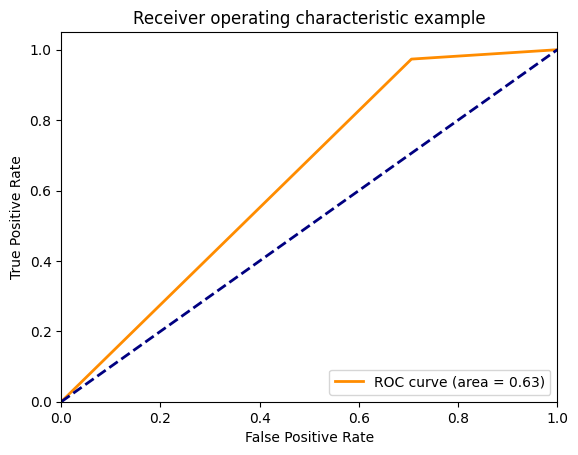

In [23]:
# PLot AUC-ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

model.eval()
y_true = []
y_pred = []
for data in test_loader:
    out = model(data)
    pred = out.max(1)[1]
    y_true.append(data.y)
    y_pred.append(pred)
y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

